# **Лабораторная работа №5**
## **Кластеризация**
## **Вариант 6: Клиенты магазина**

**Цель работы**: изучение принципов решения задачи многомерной регрессии с использованием методов машинного обучения на языке Python.

Набор данных содержит сведения о клиентах магазина, и к этим историческим данным необходимо применить сегментацию клиентов — процесс разбиения клиентской базы на группы с похожими характеристиками, что позволяет бизнесу более точно нацеливать маркетинговые усилия и распределять ресурсы; например, одна группа может включать клиентов с высоким доходом и высокой оценкой расходов, которых важно удерживать и стимулировать их лояльность, а другая — клиентов с меньшей активностью покупок, для которых целью является повышение вовлеченности через специальные предложения.

Набор данных включает следующие атрибуты:
*   Customer ID – идентификатор клиента.
*   Gender – пол клиента.
*   Age – возраст клиента в годах.
*   Annual Income – годовой доход клиента.
*   Spending Score – оценка расходов, присваиваемая магазином на основе поведения покупателя и характера расходов.
*   Work Experience – опыт работы в годах.
*   Family Size – размер семьи.
*   Profession – профессия




## Импортируем библиотеки и загружаем данные

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

df = pd.read_csv('Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


## Получим информацию о датасете

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB


## Проверяем данные на наличие пропущенных значений и выбросов

In [31]:
print(df.isnull().sum())

CustomerID                 0
Gender                     0
Age                        0
Annual Income ($)          0
Spending Score (1-100)     0
Profession                35
Work Experience            0
Family Size                0
dtype: int64


## Заполняем пропуски

In [32]:
df_copy = df.copy()
# Заполняем пропуски в столбце Profession значением 'Unknown'
df_copy['Profession'] = df_copy['Profession'].fillna(df_copy['Profession'].mode()[0])
df_copy['Profession'].isna().sum()


np.int64(0)

In [33]:
for col in ['Gender', 'Profession']:
    unique, counts = np.unique(df_copy[col], return_counts=True)
    print(f'Unique values of {col}: {unique}')
    print(f'Counts: {counts}\n')

Unique values of Gender: ['Female' 'Male']
Counts: [1186  814]

Unique values of Profession: ['Artist' 'Doctor' 'Engineer' 'Entertainment' 'Executive' 'Healthcare'
 'Homemaker' 'Lawyer' 'Marketing']
Counts: [647 161 179 234 153 339  60 142  85]



In [34]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df_copy['Gender'] = labelencoder.fit_transform(df_copy['Gender'])
df_copy['Profession'] = labelencoder.fit_transform(df_copy['Profession'])
df_copy.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,1,19,15000,39,5,1,4
1,2,1,21,35000,81,2,3,3
2,3,0,20,86000,6,2,1,1
3,4,0,23,59000,77,7,0,2
4,5,0,31,38000,40,3,2,6


## Исключаем невлияющие категориальные признаки

In [35]:
y = df_copy['CustomerID']
df_copy.drop('CustomerID', axis = 1, inplace = True)
df_copy.head()

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,19,15000,39,5,1,4
1,1,21,35000,81,2,3,3
2,0,20,86000,6,2,1,1
3,0,23,59000,77,7,0,2
4,0,31,38000,40,3,2,6


## Применяем операцию нормализации для численной устойчивости

In [36]:
# создадим объект класса StandardScaler
scaler = StandardScaler()
scaler

StandardScaler()

## Приведем данные к единому масштабу

In [37]:
X = scaler.fit_transform(df_copy)
print(X[:4,:])

[[ 1.20706357 -1.05408932 -2.09350095 -0.42833854  0.87049473 -0.79120713
   0.11749744]
 [ 1.20706357 -0.98372287 -1.65613312  1.07554599 -0.30637962 -0.28116224
  -0.39005088]
 [-0.82845678 -1.0189061  -0.54084515 -1.6099621  -0.30637962 -0.79120713
  -1.40514752]
 [-0.82845678 -0.91335643 -1.13129172  0.93231889  1.65507763 -1.04622958
  -0.8975992 ]]


## Определяем оптимальное количество кластеров с помощью метода локтя

In [38]:
from sklearn.cluster import KMeans

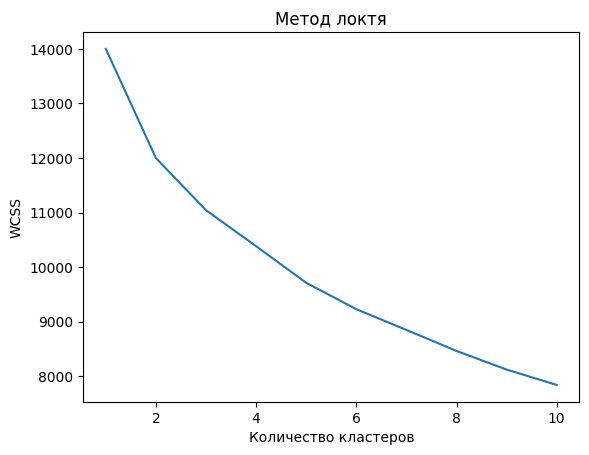

In [39]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Метод локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.show()

## Обучаем модель кластеризации

In [40]:
# создаем экземпляр модели с 5 кластерами
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
# обучаем модель на стандартизированных данных
kmeans.fit(X)


KMeans(n_clusters=5, random_state=42)

## Предсказываем кластеры и визуализируем результаты

In [41]:
# предсказываем кластеры для каждого
clusters = kmeans.predict(X)
# добавляем метки кластеров в исходные данные
df_copy['cluster'] = clusters
df_copy.head()


,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size,cluster
0,1,19,15000,39,5,1,4,0
1,1,21,35000,81,2,3,3,0
2,0,20,86000,6,2,1,1,3
3,0,23,59000,77,7,0,2,1
4,0,31,38000,40,3,2,6,2


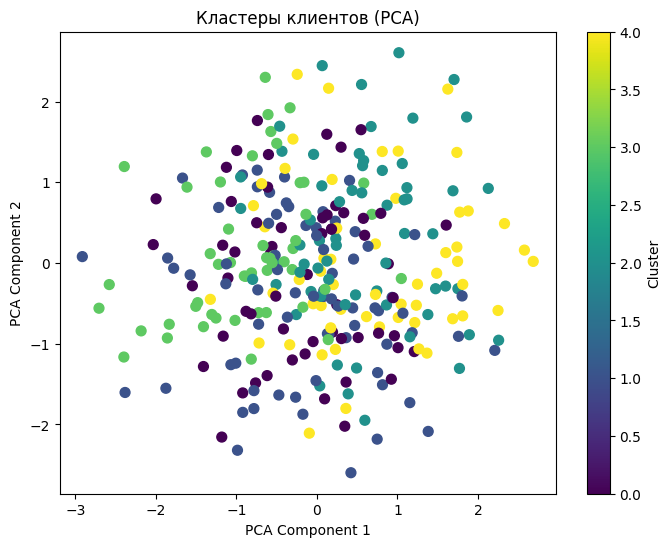

In [42]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Ограничиваем количество точек для визуализации
sample_size = 300
if X_pca.shape[0] > sample_size:
    indices = np.random.choice(X_pca.shape[0], size=sample_size, replace=False)
else:
    indices = np.arange(X_pca.shape[0])

# Построение графика
plt.figure(figsize=(8,6))
plt.scatter(X_pca[indices, 0], X_pca[indices, 1], c=clusters[indices], cmap='viridis', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Кластеры клиентов (PCA)')
plt.colorbar(label='Cluster')
plt.show()

In [43]:
# Группируем по кластерам
cluster_groups = df_copy.groupby('cluster')
# Анализ средних значений в каждом кластере
cluster_groups.mean()

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
cluster,,,,,,,
0,1.000000,49.357290,103420.901437,51.835729,2.854209,1.412731,3.934292
1,0.007576,44.174242,112415.383838,45.070707,5.696970,3.810606,3.429293
2,0.012438,56.300995,124451.087065,56.733831,1.651741,4.547264,5.659204
3,0.000000,45.786486,92544.948649,51.456757,0.886486,3.054054,2.178378
4,0.924638,48.742029,122638.272464,49.237681,2.678261,8.840580,3.426087


## Визуализация по нескольким парам разных признаков с указанием центроидов

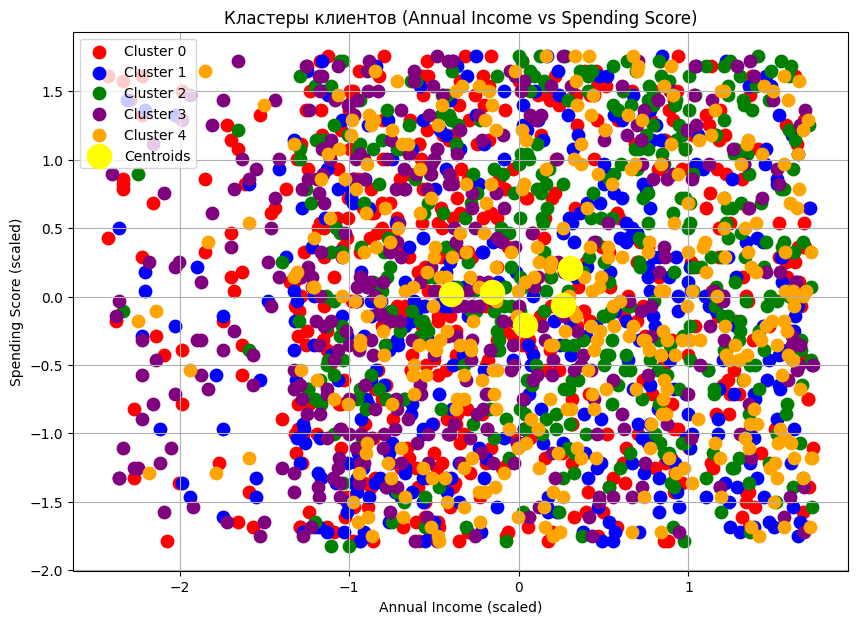

In [44]:
plt.figure(figsize=(10,7))

plt.scatter(X[clusters == 0, 2], X[clusters == 0, 3],
            s=80, c='red', label='Cluster 0')

plt.scatter(X[clusters == 1, 2], X[clusters == 1, 3],
            s=80, c='blue', label='Cluster 1')

plt.scatter(X[clusters == 2, 2], X[clusters == 2, 3],
            s=80, c='green', label='Cluster 2')

plt.scatter(X[clusters == 3, 2], X[clusters == 3, 3],
            s=80, c='purple', label='Cluster 3')

plt.scatter(X[clusters == 4, 2], X[clusters == 4, 3],
            s=80, c='orange', label='Cluster 4')

plt.scatter(kmeans.cluster_centers_[:, 2],
            kmeans.cluster_centers_[:, 3],
            s=300, c='yellow', label='Centroids')

plt.title('Кластеры клиентов (Annual Income vs Spending Score)')
plt.xlabel('Annual Income (scaled)')
plt.ylabel('Spending Score (scaled)')
plt.legend()
plt.grid(True)
plt.show()

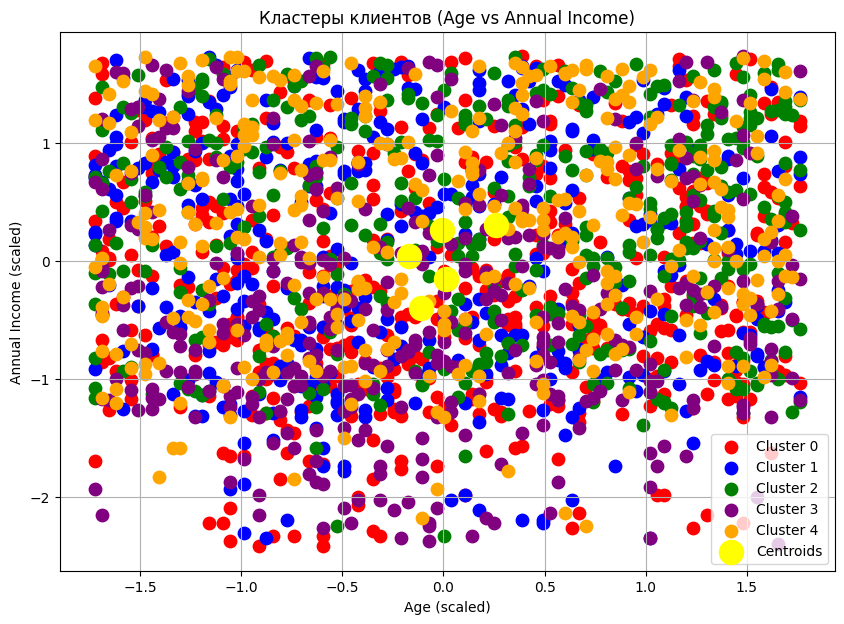

In [45]:
plt.figure(figsize=(10,7))
plt.scatter(X[clusters == 0, 1], X[clusters == 0, 2],
            s = 80, c = 'red', label = 'Cluster 0')
plt.scatter(X[clusters == 1, 1], X[clusters == 1, 2],
            s = 80, c = 'blue', label = 'Cluster 1')
plt.scatter(X[clusters == 2, 1], X[clusters == 2, 2],
            s = 80, c = 'green', label = 'Cluster 2')
plt.scatter(X[clusters == 3, 1], X[clusters == 3, 2],
            s = 80, c = 'purple', label = 'Cluster 3')
plt.scatter(X[clusters == 4, 1], X[clusters == 4, 2],
            s = 80, c = 'orange', label = 'Cluster 4')
plt.scatter(kmeans.cluster_centers_[:, 1],
            kmeans.cluster_centers_[:, 2],
            s = 300, c = 'yellow', label = 'Centroids')
plt.title('Кластеры клиентов (Age vs Annual Income)')
plt.xlabel('Age (scaled)')
plt.ylabel('Annual Income (scaled)')
plt.legend()
plt.grid(True)
plt.show()


## Интерпретация результатов

* Кластер 0: мужчины среднего возраста, умеренный доход, средние расходы, небольшая семья.

* Кластер 1: женщины среднего возраста, высокий доход, низкая покупательская активность.

* Кластер 2: женщины старшего возраста, очень высокий доход, повышенные расходы.

* Кластер 3: женщины среднего возраста с самым низким доходом, средний уровень расходов.

* Кластер 4: мужчины среднего возраста, высокий доход, средние расходы, большая семья.



In [46]:
# Добавим айди клиентов в исходные данные
df_copy['CustomerID'] = y
df_copy.head()

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size,cluster,CustomerID
0,1,19,15000,39,5,1,4,0,1
1,1,21,35000,81,2,3,3,0,2
2,0,20,86000,6,2,1,1,3,3
3,0,23,59000,77,7,0,2,1,4
4,0,31,38000,40,3,2,6,2,5


In [47]:
# Вывод айди клиентов в каждом кластере
for cluster_num in range(5):
    print(f"\nCluster {cluster_num} IDs:")
    print(df_copy[df_copy['cluster'] == cluster_num]['CustomerID'].values)


Cluster 0 IDs:
[   1    2    9   11   15   16   18   19   22   24   26   28   31   33
   42   52   54   60   61   66   69   75   76   78   81   82   86   92
   93   99  100  103  104  108  109  111  114  121  124  127  128  129
  132  135  138  142  145  151  152  157  159  163  165  170  171  172
  173  174  178  179  188  198  199  200  208  213  215  217  223  229
  232  237  238  239  241  247  251  256  258  260  266  271  276  277
  278  280  286  299  300  301  311  315  326  331  333  334  342  343
  362  365  366  378  382  383  386  409  411  414  421  424  427  428
  429  430  438  439  442  457  459  463  465  477  478  479  480  483
  486  488  493  498  500  508  513  515  517  529  530  537  539  541
  547  551  556  557  558  560  566  571  580  586  611  615  619  622
  624  626  628  631  633  634  643  652  654  656  658  660  661  669
  671  675  678  681  682  683  692  693  696  699  700  704  705  708
  709  710  714  721  727  728  729  730  732  738  739  742 